# Proof-of-Concept: Nigeria 2018

*This proof-of-concept illustrates operational feasibility and produces plausible outputs, though parameter choices are assumption-based rather than empirically validated.*

In [4]:
from fea_mesh_2d import *
from conflict_translation import *
from social_characteristics_translation import *

## Create Plate Mesh

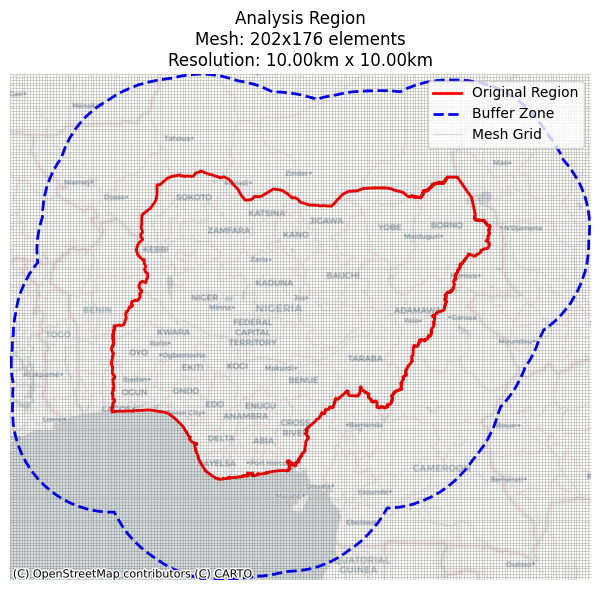

In [5]:
mesh = FEAMesh2D(width=1.0, height=1.0, nx=1, ny=1)

mesh._set_region_from_shapefile(
    shapefile_path='./data/nigeria_adm0/nigeria.shp',
    buffer_distance=350_000,  # meters #150km
    mesh_resolution=10_000,  # meters per element
    visualize=True,
    verbose=False
)

In [6]:
verify_mesh_creation(mesh)

Mesh Verification:
Elements: 202 x 176
Expected nodes: 35931, Actual: 35931
Expected DOFs: 107793, Actual: 107793


## Setup - Material Properties

### Create Indicator Manager with Base Values

In [7]:
manager = IndicatorManager(
    mesh=mesh,
    base_thickness=2_500,
    base_youngs_modulus=5e9,
    poisson_ratio_k=2.5
)

### Import Indicators & Map them with Response Functions

#### Thickness

##### Critical Infrastructure Spatial Index

In [8]:
cisi = Indicator(
    name='critical-infrastructure-spatial-index',
    tiff_path='./data/spatial_data/CISI_critical_infrastructure_index_clipped.tif',
    indicator_type='r',
    resampling_method='average',
)

# Add parameter mappings
cisi.add_parameter_mapping(
    parameter_type=ParameterType.THICKNESS,
    response_config=ResponseConfig(
        function_type=ResponseType.POWER_LAW,
        parameters={'gamma': 0.5},
        range_type=RangeType.RESILIENCE
    ),
    weight=0.15
)

# Add indicator to manager
manager.add_indicator(cisi)

##### Standard Precipitation Index - Drought

In [9]:
spi_drought = Indicator(
    name='standard-precipitation-index-drought',
    tiff_path='./data/spatial_data/spi_CHIRPS_standard_precipitation_drought_2018_clipped.tif',
    indicator_type='v',
    resampling_method='average',
    flip_data=True
)

# Add parameter mappings
spi_drought.add_parameter_mapping(
    parameter_type=ParameterType.THICKNESS,
    response_config=ResponseConfig(
        function_type=ResponseType.POWER_LAW,
        parameters={'gamma': 3},
        range_type=RangeType.VULNERABILITY
    ),
    weight=0.2
)

# Add indicator to manager
manager.add_indicator(spi_drought)

##### Standard Precipitation Index - Wetness

In [10]:
spi_wetness = Indicator(
    name='standard-precipitation-index-wetness',
    tiff_path='./data/spatial_data/spi_CHIRPS_standard_precipitation_wetness_2018_clipped.tif',
    indicator_type='v',
    resampling_method='average',
)

# Add parameter mappings
spi_wetness.add_parameter_mapping(
    parameter_type=ParameterType.THICKNESS,
    response_config=ResponseConfig(
        function_type=ResponseType.POWER_LAW,
        parameters={'gamma': 3},
        range_type=RangeType.VULNERABILITY,
    ),
    weight=0.2
)

# Add indicator to manager
manager.add_indicator(spi_wetness)

##### Health Infrastructure Density including Travel Time Dependency

In [11]:
health_infrastructure = Indicator(
    name="infrastructure",
    tiff_path='./data/spatial_data/health_infrastructure_density_combined_clipped.tif',
    indicator_type='r',
    resampling_method='average',
)

health_travel_time = Indicator(
    name='health-travel-time',
    tiff_path='./data/spatial_data/2020_walking_travel_time_healthcare_clipped.tif',
    indicator_type='p',
    resampling_method='average',
)

# Prerequisite with reverse=True for full effect before threshold
travel_time_dependency = PrerequisiteConfig(
   indicator_name='health-travel-time',
   response_config=ResponseConfig(
       function_type=ResponseType.LINEAR,
       parameters={'m': 1.0},
       range_type=RangeType.PREREQUISITE
   ),
   threshold=0.03,
   base_level=0.4,
   reverse=True    # Reverse the threshold effect
)

health_infrastructure.add_parameter_mapping(
   parameter_type=ParameterType.THICKNESS,
   response_config=ResponseConfig(
       function_type=ResponseType.LOGARITHMIC,
       parameters={'alpha': 2.5},
       range_type=RangeType.RESILIENCE
   ),
   weight=0.3,
   prerequisite_config=travel_time_dependency
)

manager.add_indicator(health_travel_time)
manager.add_indicator(health_infrastructure)

##### Dependency Ratio on Working-Age Population

In [12]:
dependency_ratio = Indicator(
    name='dependency_ratio',
    tiff_path='./data/spatial_data/dependency_ratio_young_and_old_clipped.tif',
    indicator_type='v',
    resampling_method='average',
)

# Add parameter mappings
dependency_ratio.add_parameter_mapping(
    parameter_type=ParameterType.THICKNESS,
    response_config=ResponseConfig(
        function_type=ResponseType.EXPONENTIAL,
        parameters={'beta': 0.8},
        range_type=RangeType.VULNERABILITY,
    ),
    weight=0.15
)

# Add indicator to manager
manager.add_indicator(dependency_ratio, validate=True)

Current weight sum for thickness: 1.000


#### Young's Modulus

##### GDP

In [13]:
gdp = Indicator(
    name='gdp',
    tiff_path='./data/spatial_data/GDP_PPP_30arcsec_v3_2015_clipped.tif',
    indicator_type='r',
    resampling_method='average',
)

# Add parameter mappings
gdp.add_parameter_mapping(
    parameter_type=ParameterType.YOUNGS_MODULUS,
    response_config=ResponseConfig(
        function_type=ResponseType.LINEAR,
        parameters={'m': 1.0},
        range_type=RangeType.RESILIENCE,
    ),
    weight=0.6
)

# Add indicator to manager
manager.add_indicator(gdp)

##### Poverty Index

In [14]:
poverty_index = Indicator(
    name='poverty-index',
    tiff_path='./data/spatial_data/nga10povcons200.tif',
    indicator_type='v',
    resampling_method='average',
)

# Add parameter mappings
poverty_index.add_parameter_mapping(
    parameter_type=ParameterType.YOUNGS_MODULUS,
    response_config=ResponseConfig(
        function_type=ResponseType.POWER_LAW,
        parameters={'gamma': 1.5},
        range_type=RangeType.VULNERABILITY
    ),
    weight=0.2
)

# Add indicator to manager
manager.add_indicator(poverty_index)

##### Proportion of 12-23 Months Olds Born to the Poorest Households

In [15]:
children_poorest_households = Indicator(
    name='children-poorest-households',
    tiff_path='./data/spatial_data/NGA_HWEALTH_MEAN.tif',
    indicator_type='v',
    resampling_method='average',
)

# Add parameter mappings
children_poorest_households.add_parameter_mapping(
    parameter_type=ParameterType.YOUNGS_MODULUS,
    response_config=ResponseConfig(
        function_type=ResponseType.POWER_LAW,
        parameters={'gamma': 0.5},
        range_type=RangeType.VULNERABILITY,
    ),
    weight=0.2
)

# Add indicator to manager
manager.add_indicator(children_poorest_households, validate=True)

Current weight sum for thickness: 1.000
Current weight sum for youngs_modulus: 1.000


#### Poisson's Ratio

##### Population Density

In [16]:
population_density = Indicator(
    name='population-density',
    tiff_path='./data/spatial_data/nga_pd_2020_1km_UNadj.tif',
    indicator_type='v',
    resampling_method='average',
)

# Add parameter mappings
population_density.add_parameter_mapping(
    parameter_type=ParameterType.POISSON_RATIO,
    response_config=ResponseConfig(
        function_type=ResponseType.LINEAR,
        parameters={'m': 2.0},
        range_type=RangeType.VULNERABILITY,
    ),
    weight=0.6
)

# Add indicator to manager
manager.add_indicator(population_density)

##### Road Density

In [17]:
road_density = Indicator(
    name='road-density',
    tiff_path='./data/spatial_data/road_density_clipped.tif',
    indicator_type='r',
    resampling_method='average',
)

# Add parameter mappings
road_density.add_parameter_mapping(
    parameter_type=ParameterType.POISSON_RATIO,
    response_config=ResponseConfig(
        function_type=ResponseType.LOGARITHMIC,
        parameters={'alpha': 2},
        range_type=RangeType.RESILIENCE,
    ),
    weight=0.4
)

# Add indicator to manager
manager.add_indicator(road_density, validate=True)

Current weight sum for thickness: 1.000
Current weight sum for youngs_modulus: 1.000
Current weight sum for poisson_ratio: 1.000


### Load Indicator Data & Compute Physical Parameters


Processing TIFF: ./data/spatial_data/CISI_critical_infrastructure_index_clipped.tif
Source Details:
CRS: EPSG:4326
Bounds: BoundingBox(left=1.7, bottom=3.3583328199999993, right=15.6, top=14.85833282)
Original shape: (115, 139)

Valid data range: [0.000000, 0.504439]


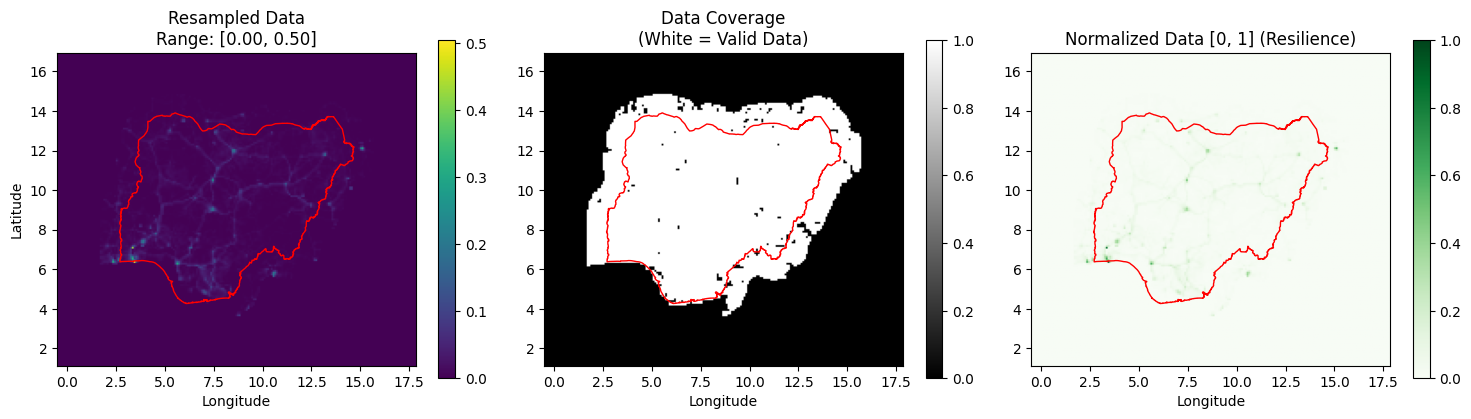


Processing TIFF: ./data/spatial_data/spi_CHIRPS_standard_precipitation_drought_2018_clipped.tif
Source Details:
CRS: EPSG:4326
Bounds: BoundingBox(left=1.7, bottom=3.299999999999999, right=15.65, top=14.85)
Original shape: (231, 279)

Valid data range: [0.041218, 1.956173]


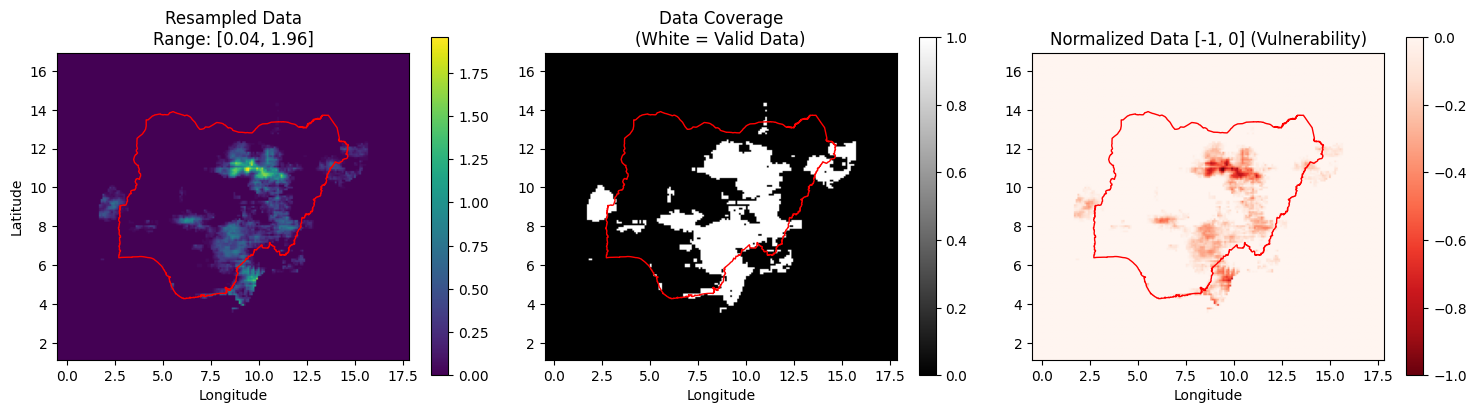


Processing TIFF: ./data/spatial_data/spi_CHIRPS_standard_precipitation_wetness_2018_clipped.tif
Source Details:
CRS: EPSG:4326
Bounds: BoundingBox(left=1.7, bottom=3.299999999999999, right=15.65, top=14.85)
Original shape: (231, 279)

Valid data range: [0.041218, 2.014946]


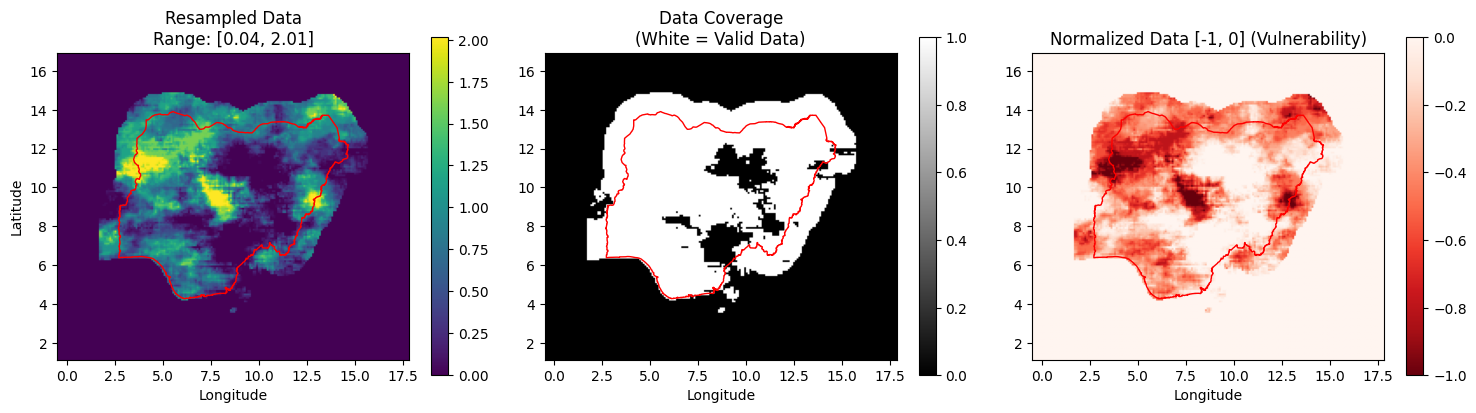


Processing TIFF: ./data/spatial_data/2020_walking_travel_time_healthcare_clipped.tif
Source Details:
CRS: EPSG:4326
Bounds: BoundingBox(left=1.675, bottom=3.275000000000002, right=15.666666667, top=14.883333333)
Original shape: (1393, 1679)

Valid data range: [3.402443, 937.387125]


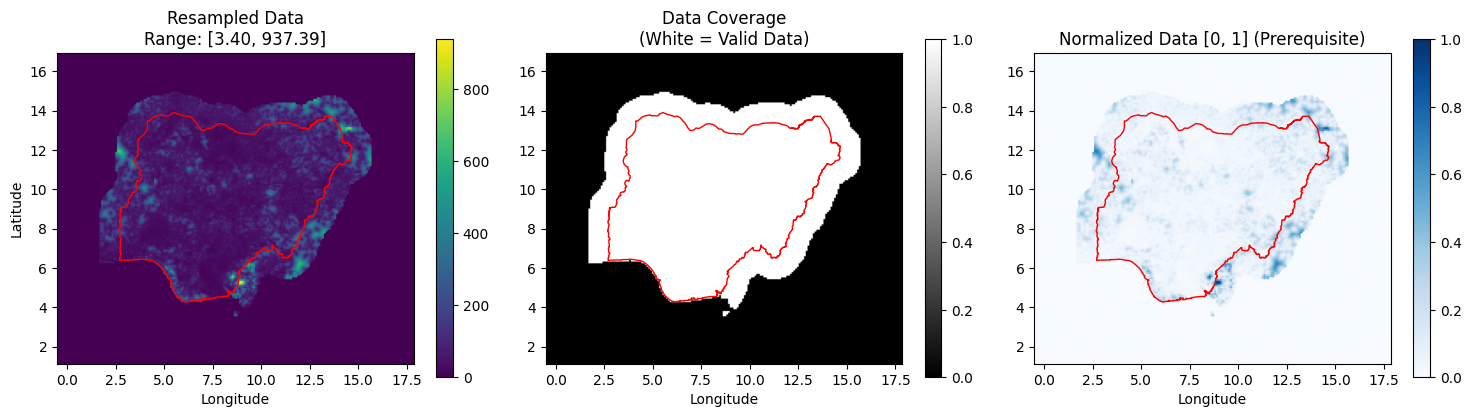


Processing TIFF: ./data/spatial_data/health_infrastructure_density_combined_clipped.tif
Source Details:
CRS: EPSG:4326
Bounds: BoundingBox(left=1.7, bottom=3.3583300000000005, right=15.6, top=14.85833)
Original shape: (115, 139)

Valid data range: [0.000020, 94.787388]


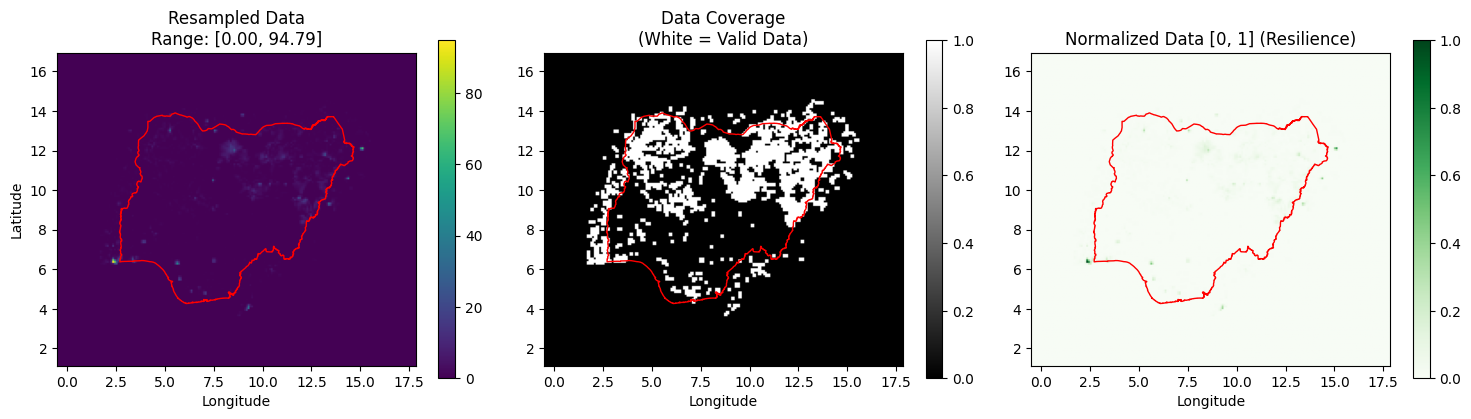


Processing TIFF: ./data/spatial_data/dependency_ratio_young_and_old_clipped.tif
Source Details:
CRS: EPSG:4326
Bounds: BoundingBox(left=2.666249236, bottom=4.274583686, right=14.674582521000001, top=13.899583647)
Original shape: (1155, 1441)

Valid data range: [53.098869, 173.421921]


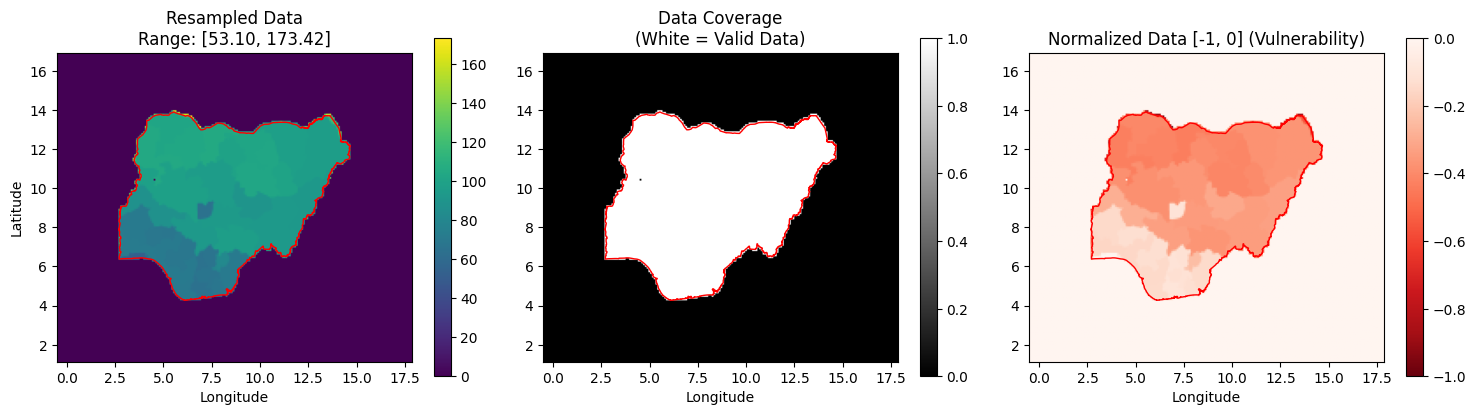


Processing TIFF: ./data/spatial_data/GDP_PPP_30arcsec_v3_2015_clipped.tif
Source Details:
CRS: EPSG:4326
Bounds: BoundingBox(left=2.666666667, bottom=4.275, right=14.675, top=13.9)
Original shape: (1155, 1441)

Valid data range: [4294.606934, 280552962.500000]


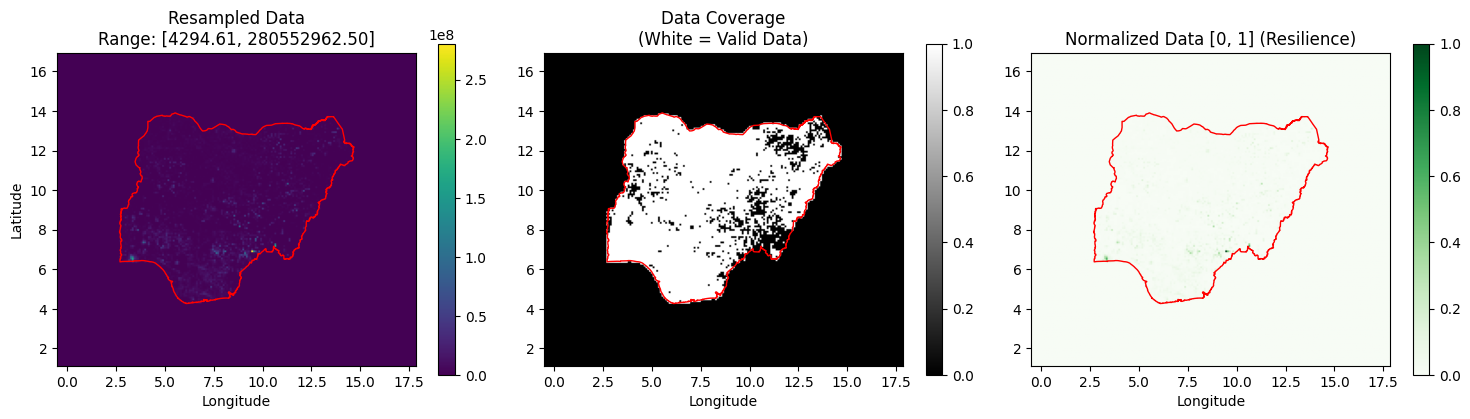


Processing TIFF: ./data/spatial_data/nga10povcons200.tif
Source Details:
CRS: EPSG:4326
Bounds: BoundingBox(left=-5.00007, bottom=-2.3999999999801958e-05, right=20.00825333, top=15.00830333)
Original shape: (1801, 3001)

Valid data range: [0.195386, 0.953128]


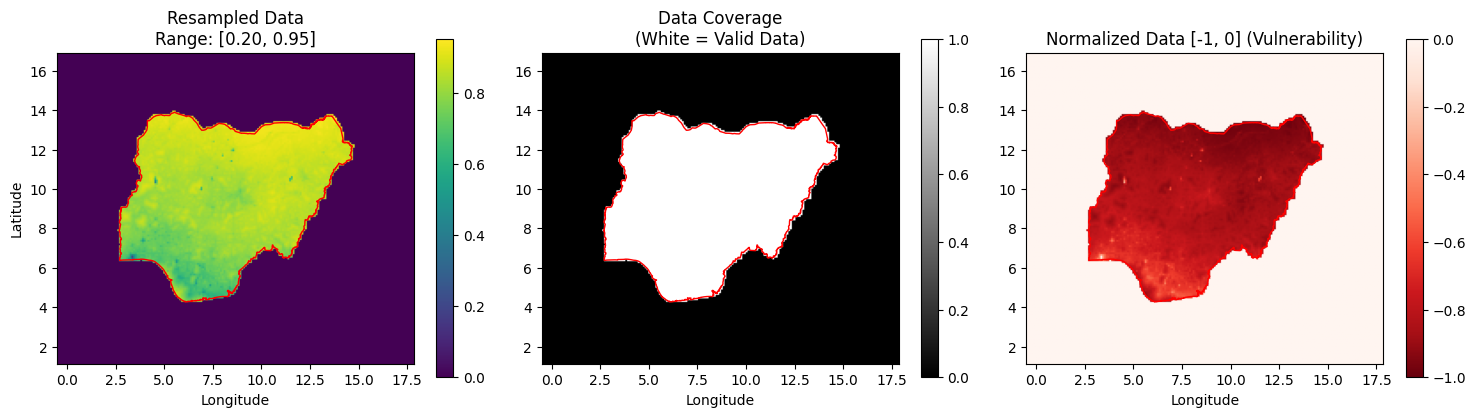


Processing TIFF: ./data/spatial_data/NGA_HWEALTH_MEAN.tif
Source Details:
CRS: EPSG:4326
Bounds: BoundingBox(left=2.666666666, bottom=4.266666704, right=14.683333285, top=13.899999999)
Original shape: (1156, 1442)

Valid data range: [0.000091, 1.000000]


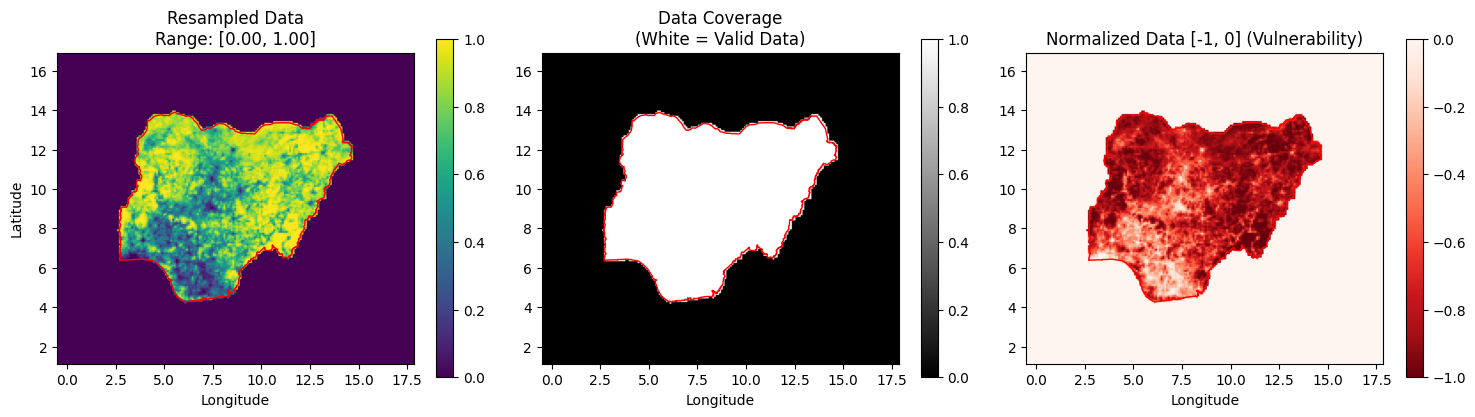


Processing TIFF: ./data/spatial_data/nga_pd_2020_1km_UNadj.tif
Source Details:
CRS: EPSG:4326
Bounds: BoundingBox(left=2.673749989597212, bottom=4.266250186455377, right=14.682083274897213, top=13.899583481255377)
Original shape: (1156, 1441)

Valid data range: [4.340865, 29771.863955]


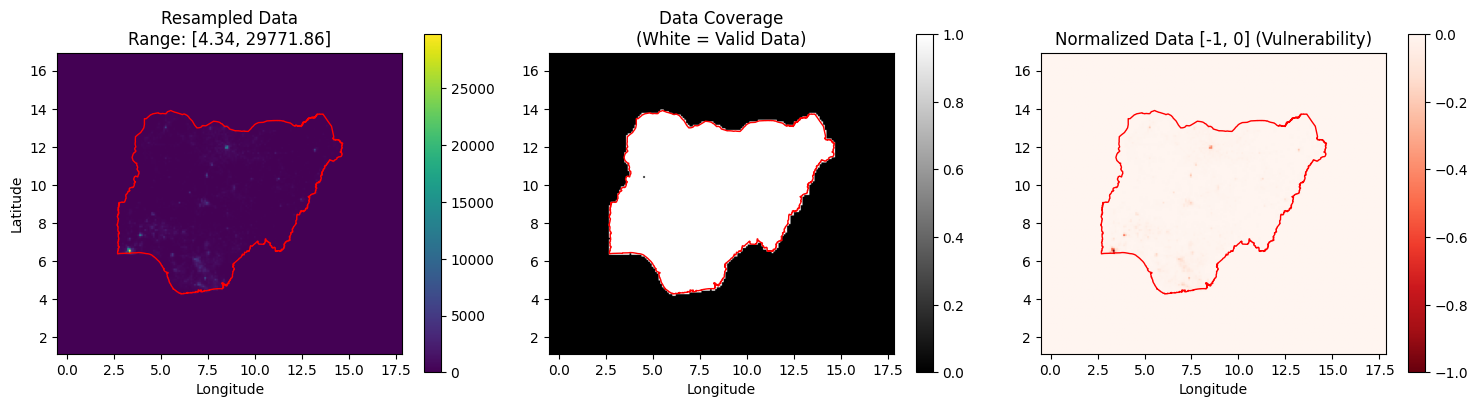


Processing TIFF: ./data/spatial_data/road_density_clipped.tif
Source Details:
CRS: EPSG:4326
Bounds: BoundingBox(left=1.75, bottom=3.3333333330000006, right=15.666666667, top=14.833333333)
Original shape: (138, 167)

Valid data range: [0.006978, 7664.076431]


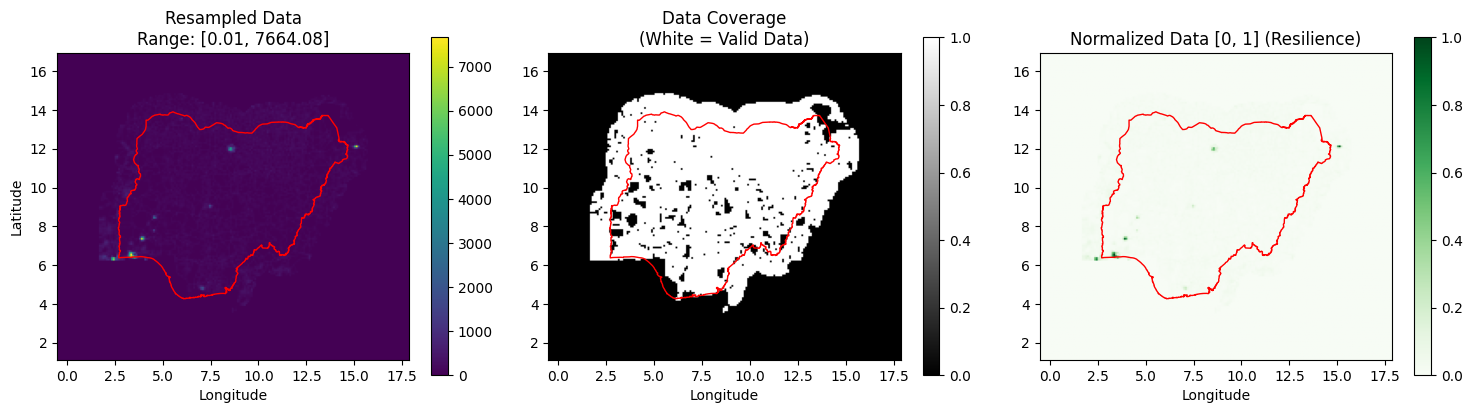

In [18]:
# Load data for all indicators
for indicator_name in manager.indicators:
    manager.load_indicator_data(indicator_name)

# Compute parameters
thickness = manager.compute_parameter(ParameterType.THICKNESS)
youngs_modulus = manager.compute_parameter(ParameterType.YOUNGS_MODULUS)
poisson_ratio = manager.compute_parameter(ParameterType.POISSON_RATIO)

### Plot Physical Parameters

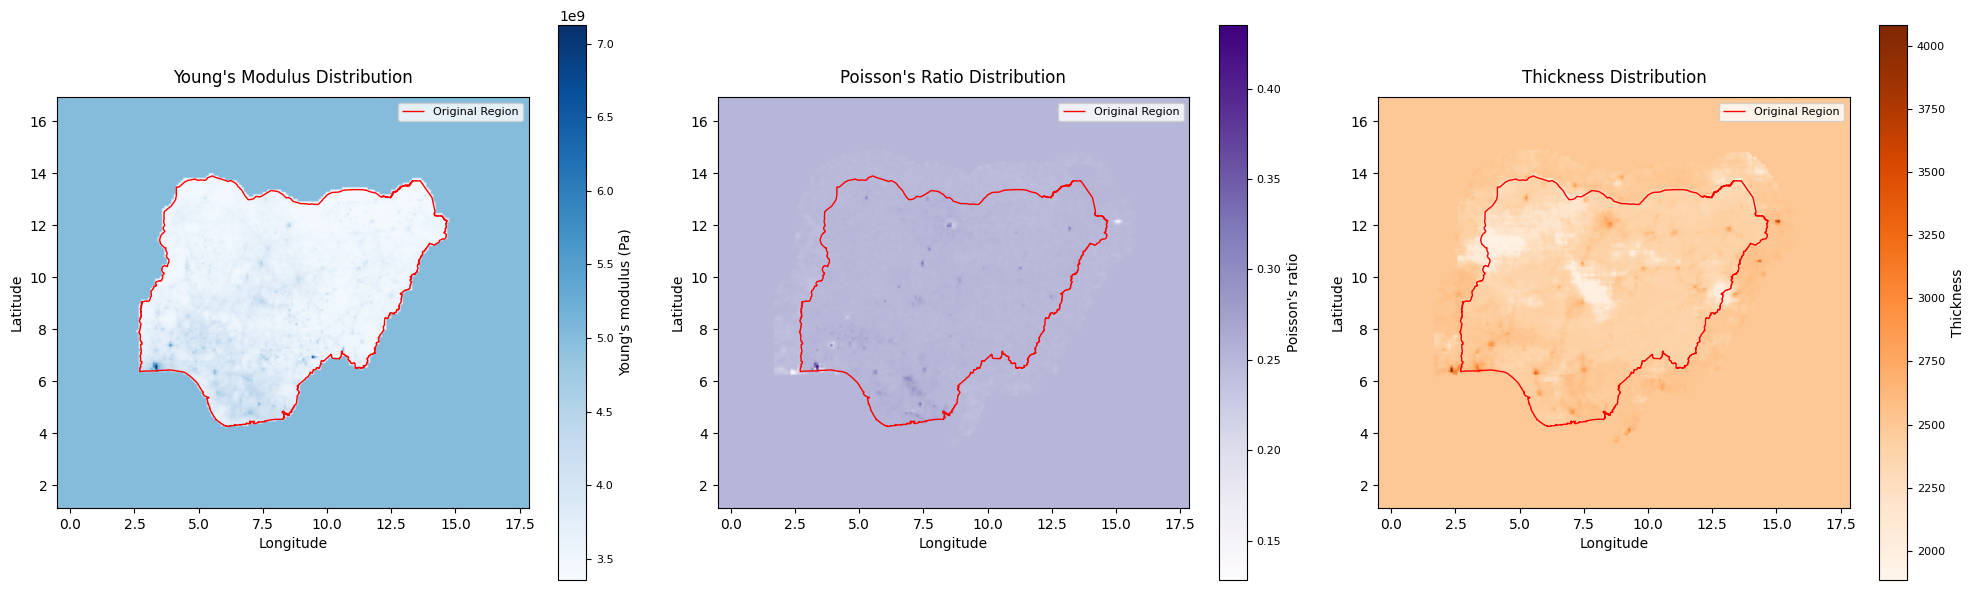

In [19]:
parameter_values = {
    ParameterType.YOUNGS_MODULUS: youngs_modulus,
    ParameterType.POISSON_RATIO: poisson_ratio,
    ParameterType.THICKNESS: thickness
}

manager.visualize_parameters(parameter_values, single_row=True)

### Apply Physical Parameters to Mesh

In [20]:
# Apply all properties to the mesh
mesh.E = youngs_modulus
mesh.nu = poisson_ratio
mesh.thickness = thickness

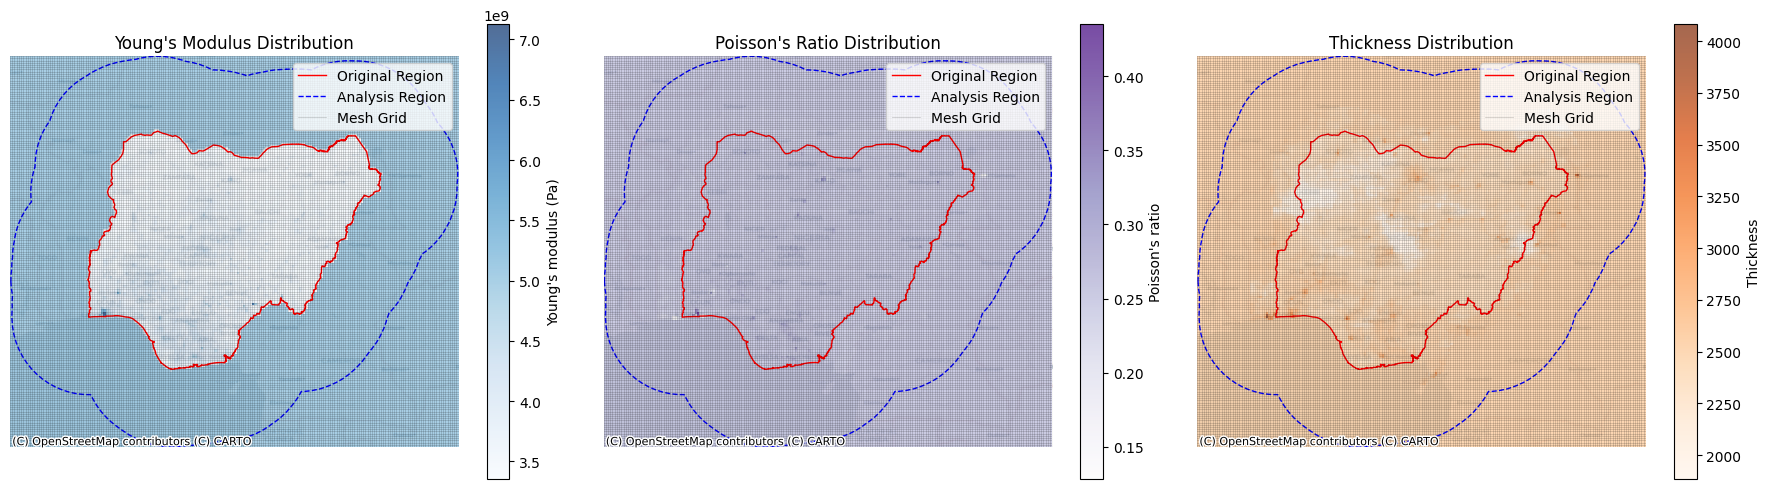

In [21]:
# Visualize final properties
mesh._visualize_properties()

In [22]:
# Update element mapping for plate bending
mesh._create_element_mapping()

In [23]:
# Verify material property ranges
print(f"Young's modulus range: {np.min(mesh.E):.2e} to {np.max(mesh.E):.2e} Pa")
print(f"Poisson's ratio range: {np.min(mesh.nu):.3f} to {np.max(mesh.nu):.3f}")
print(f"Plate thickness: {np.min(mesh.thickness):.2f} to {np.max(mesh.thickness):.2f} m")

Young's modulus range: 3.35e+09 to 7.13e+09 Pa
Poisson's ratio range: 0.128 to 0.435
Plate thickness: 1884.58 to 4081.61 m


## Setup - Boundary Conditions

In [24]:
# Set up boundary conditions - all edges fixed
fixed_nodes = mesh._get_boundary_nodes('clamped_all')

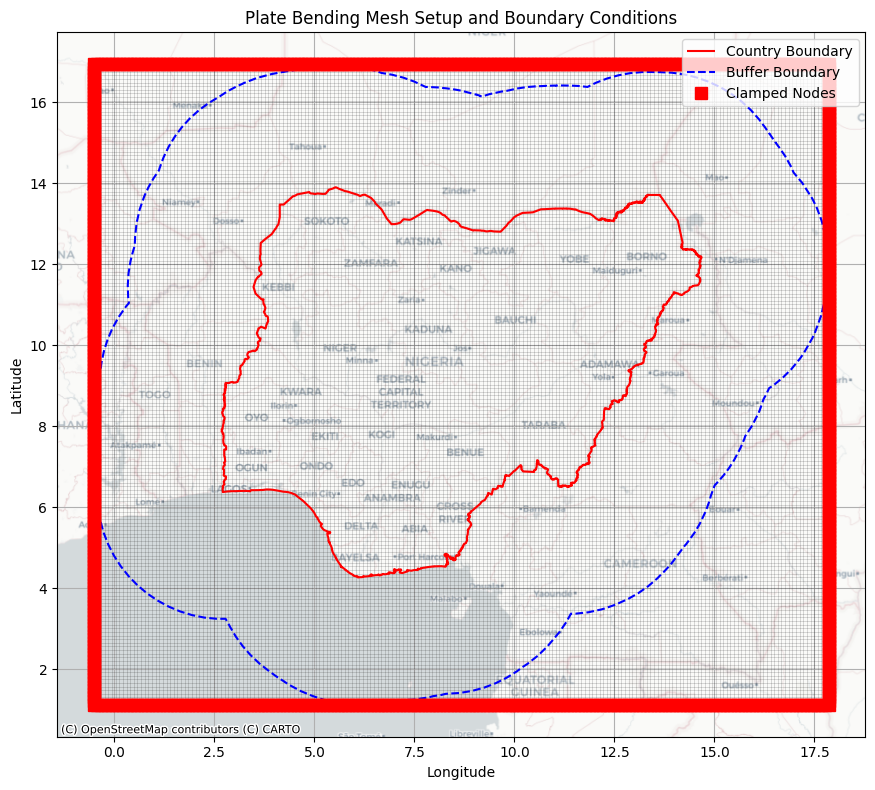

In [25]:
mesh._visualize_mesh_setup(fixed_nodes)

In [26]:
# Check boundary condition application
n_fixed_dofs = len(fixed_nodes)
print(f"Number of fixed DOFs: {n_fixed_dofs}")
print(f"Percentage of constrained DOFs: {100 * n_fixed_dofs / mesh.ndof:.1f}%")

Number of fixed DOFs: 2268
Percentage of constrained DOFs: 2.1%


## Create Force Configurations

### Event Type Configurations

In [27]:
event_type_config = {
    'Battles': ForceConfig(
        # Force Magnitude Mapping
        base_magnitude=8.0e8,
        fatality_weight=0.4,
        civilian_factor=0.75,
        decay_rate=0.0064,

        # Force Distribution Mapping
        distribution=Distribution.LINEAR,

        # Force Radius Mapping
        base_radius=25_000,
        expansion_rate=0.0512,
        max_expansion=0.5
    ),
    'Explosions/Remote violence': ForceConfig(
        # Force Magnitude Mapping
        base_magnitude=1.0e9,
        fatality_weight=0.4,
        civilian_factor=0.75,
        decay_rate=0.0064,

        # Force Distribution Mapping
        distribution=Distribution.GAUSSIAN,

        # Force Radius Mapping
        base_radius=10_000,
        expansion_rate=0.0512,
        max_expansion=0.5
    ),
    'Violence against civilians': ForceConfig(
        # Force Magnitude Mapping
        base_magnitude=6.0e8,
        fatality_weight=0.2,
        civilian_factor=0.75,
        decay_rate=0.0128,

        # Force Distribution Mapping
        distribution=Distribution.POINT,

        # Force Radius Mapping
        base_radius=0, # N/A
        expansion_rate=0, # N/A
        max_expansion=0 # N/A
    ),
    'Riots': ForceConfig(
        # Force Magnitude Mapping
        base_magnitude=3.0e8,
        fatality_weight=0.3,
        civilian_factor=0.75,
        decay_rate=0.0256,

        # Force Distribution Mapping
        distribution=Distribution.CONSTANT,

        # Force Radius Mapping
        base_radius=5_000,
        expansion_rate=0.3070,
        max_expansion=0.1
    ),
    'Protests': ForceConfig(
        # Force Magnitude Mapping
        base_magnitude=1.0e8,
        fatality_weight=0.3,
        civilian_factor=0.75,
        decay_rate=0.0256,

        # Force Distribution Mapping
        distribution=Distribution.CONSTANT,

        # Force Radius Mapping
        base_radius=5_000,
        expansion_rate=0.3070,
        max_expansion=0.1
    )
}

### Sub-Event Type Configurations

In [28]:
# Overwrites the specific sub-event types of the event type configurations
subevent_type_config = {
        'Chemical weapon': ForceConfig(
            # Force Magnitude Mapping
            base_magnitude=1.0e9,
            fatality_weight=0.4,
            civilian_factor=0.75,
            decay_rate=0.0064,

            # Force Distribution Mapping
            distribution=Distribution.LINEAR,

            # Force Radius Mapping
            base_radius=10_000,
            expansion_rate=0.0512,
            max_expansion=0.5
        ),
        'Shelling/artillery/missile attack': ForceConfig(
            # Force Magnitude Mapping
            base_magnitude=1.0e9,
            fatality_weight=0.4,
            civilian_factor=0.75,
            decay_rate=0.0064,

            # Force Distribution Mapping
            distribution=Distribution.LINEAR,

            # Force Radius Mapping
            base_radius=10_000,
            expansion_rate=0.0512,
            max_expansion=0.5
        )
    }

### Event Translator

In [29]:
# Configure democracy adjustment
democracy_adjustment = {
    'Protests': {
        'apply_to': ['event_type'],  # Apply to all protests
        'types': True  # Apply to all protest types
    }
}

In [30]:
translator = EventTranslator(
    democracy_index=0.4,
    event_type_config=event_type_config,
    subevent_type_config=subevent_type_config,
    democracy_adjustment=democracy_adjustment
)

### Process Conflict Data (ACLED) - Previously Exported as CSV

In [31]:
acled_data = pd.read_csv('./data/ACLED_CONFLICT-EVENTS_2018-01-01-2018-12-31-Nigeria.csv')

# filter for only events with geo-precision 1 and exclude 'Strategic developments'
acled_data_filtered = acled_data[(acled_data['event_type'] != 'Strategic developments') & (acled_data['geo_precision'] == 1)].copy()
# acled_data_filtered = acled_data[(acled_data['event_type'] != 'Strategic developments') & (acled_data['event_type'] != 'Battles') & (acled_data['geo_precision'] == 1)].copy()

In [32]:
# convert 'event_date' column to a datetime type
acled_data_filtered['event_date'] = pd.to_datetime(acled_data_filtered['event_date'])

# convert 'civilian_targeting' column to a boolean type
acled_data_filtered['civilian_targeting'] = acled_data_filtered['civilian_targeting'] == 'Civilian targeting'

In [33]:
acled_data_filtered.tail(5)

event_id_cnty event_date  year  time_precision       disorder_type  \
2033      NIG11642 2018-01-02  2018               1  Political violence   
2035      NIG11634 2018-01-01  2018               1  Political violence   
2042      NIG11640 2018-01-01  2018               1  Political violence   
2044      NIG11632 2018-01-01  2018               1  Political violence   
2048      NIG11636 2018-01-01  2018               1  Political violence   

                      event_type                 sub_event_type  \
2033                       Riots                   Mob violence   
2035  Explosions/Remote violence  Remote explosive/landmine/IED   
2042  Violence against civilians                Sexual violence   
2044                     Battles                    Armed clash   
2048  Violence against civilians                         Attack   

                                      actor1                  assoc_actor_1  \
2033                       Rioters (Nigeria)  Foko Communal Group (Nigeria)   
2035      Unidentified Armed Group (Nigeria)                            NaN   
2042                Muslim Militia (Nigeria)                            NaN   
2044  Military Forces of Nigeria (2015-2023)                            NaN   
2048      Unidentified Armed Group (Nigeria)                            NaN   

                 inter1  ...  location latitude longitude geo_precision  \
2033            Rioters  ...   Oke Ado   7.3727    3.8777             1   
2035  Political militia  ...  Madagali  10.8864   13.6300             1   
2042   Identity militia  ...   Illorin   8.5000    4.5500             1   
2044       State forces  ...     Ndoro   5.0417    5.5972             1   
2048  Political militia  ...     Omoku   5.3435    6.6532             1   

                           source  source_scale  \
2033  Daily Independent (Nigeria)      National   
2035             Nation (Nigeria)      National   
2042                Sun (Nigeria)      National   
2044           Vanguard (Nigeria)      National   
2048           This Day (Nigeria)      National   

                                                  notes fatalities tags  \
2033  'Youths' or 'hoodlums' from Foko and Itamaya a...          0  NaN   
2035  Three people are believed dead in a bomb attac...          3  NaN   
2042  Christian and Muslim violence continues in Ill...          0  NaN   
2044  A security official is beheaded by 'militants'...          1  NaN   
2048  Unidentified gunmen opened fire on a group of ...         17  NaN   

       timestamp  
2033  1702343560  
2035  1561469190  
2042  1571164641  
2044  1686096159  
2048  1702343560  

[5 rows x 31 columns]

### Translate Events in DataFrame

In [34]:
reference_date = datetime(2018, 12, 31)

In [35]:
force_configs = translator.translate_events(
        acled_data_filtered,
        current_date=reference_date
    )
# display_forces_summary(force_configs)

### Visualize Conflict Mappings

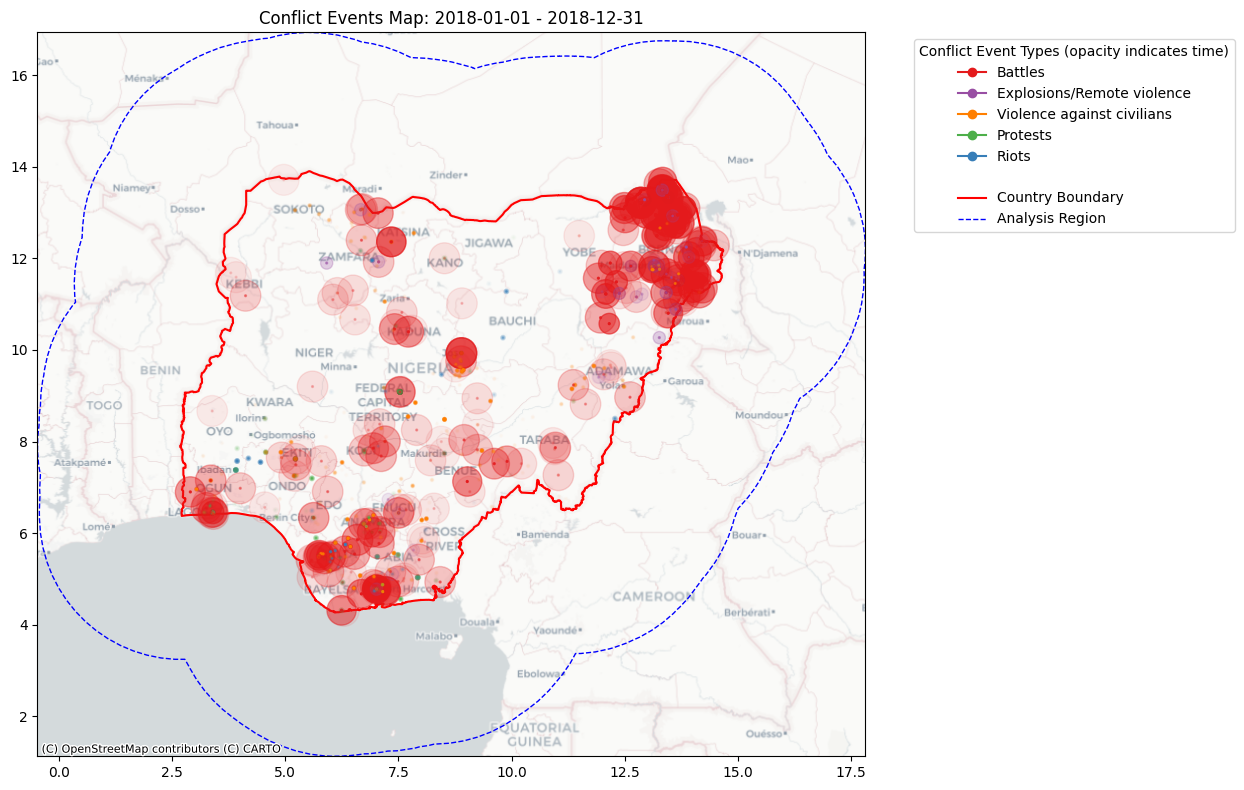

In [36]:
visualize_conflict_events(mesh=mesh, events_df=acled_data_filtered, current_date=reference_date, translator=translator, legend=True)

## Apply Forces to Mesh

In [37]:
# Solve and visualise

# ***** Uncomment the next line to run the actual analysis
# ***** It will take 2-3 hours for this analysis, tested on a MacBook Pro M4
# u = apply_multiple_forces(mesh, force_configs, fixed_nodes)

## Save/Read Results

In [38]:
# ***** Uncomment to save the analysis results
# np.save('./output/displacements_01-01-2018_to_31_12_2018', u)

In [39]:
# Load the analysis results from previous run
u = np.load('./output/displacements_01-01-2018_to_31_12_2018.npy')

## Visualization

(<Figure size 1200x800 with 2 Axes>,
 <Axes: title={'center': 'Displacement Distribution'}, xlabel='Longitude', ylabel='Latitude'>)

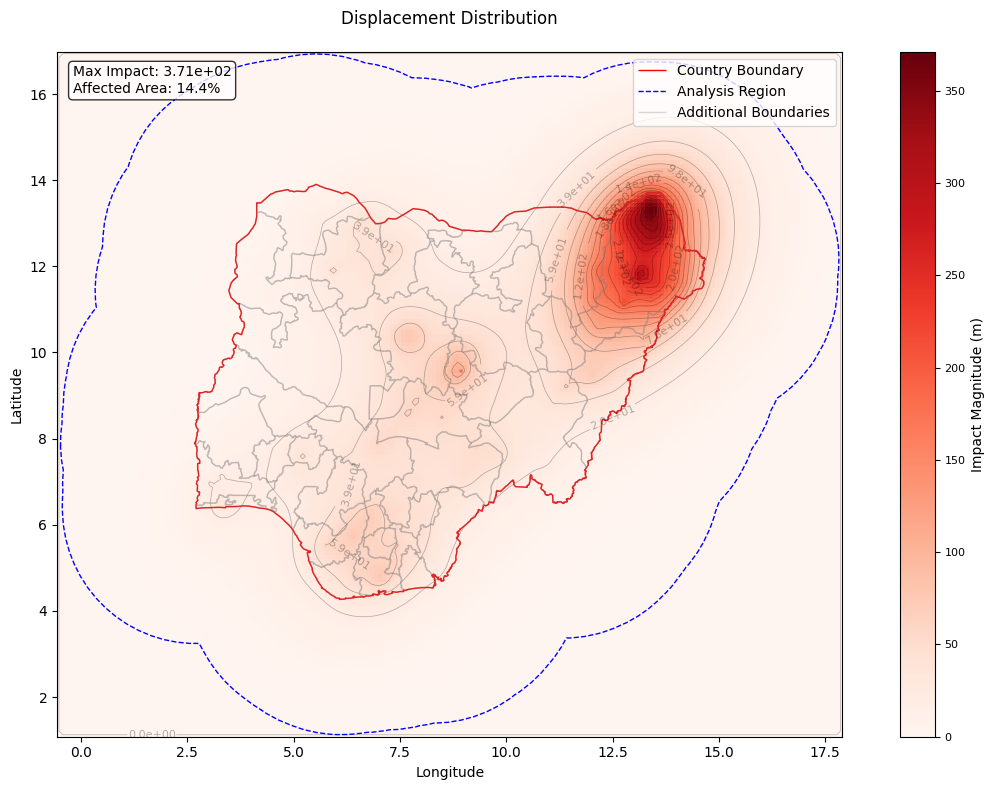

In [40]:
# For basic displacement plot
mesh._plot_results(u, plot_type='displacement', additional_boundaries_file='./data/nigeria_adm1/adm1.shp')

In [41]:
fig = mesh.plot_interactive(u, additional_boundaries_file='./data/nigeria_adm1/adm1.shp')
fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.surface.ColorBar: 'titleside'

Did you mean "title"?

    Valid properties:
        bgcolor
            Sets the color of padded area.
        bordercolor
            Sets the axis line color.
        borderwidth
            Sets the width (in px) or the border enclosing this
            color bar.
        dtick
            Sets the step in-between ticks on this axis. Use with
            `tick0`. Must be a positive number, or special strings
            available to "log" and "date" axes. If the axis `type`
            is "log", then ticks are set every 10^(n*dtick) where n
            is the tick number. For example, to set a tick mark at
            1, 10, 100, 1000, ... set dtick to 1. To set tick marks
            at 1, 100, 10000, ... set dtick to 2. To set tick marks
            at 1, 5, 25, 125, 625, 3125, ... set dtick to
            log_10(5), or 0.69897000433. "log" has several special
            values; "L<f>", where `f` is a positive number, gives
            ticks linearly spaced in value (but not position). For
            example `tick0` = 0.1, `dtick` = "L0.5" will put ticks
            at 0.1, 0.6, 1.1, 1.6 etc. To show powers of 10 plus
            small digits between, use "D1" (all digits) or "D2"
            (only 2 and 5). `tick0` is ignored for "D1" and "D2".
            If the axis `type` is "date", then you must convert the
            time to milliseconds. For example, to set the interval
            between ticks to one day, set `dtick` to 86400000.0.
            "date" also has special values "M<n>" gives ticks
            spaced by a number of months. `n` must be a positive
            integer. To set ticks on the 15th of every third month,
            set `tick0` to "2000-01-15" and `dtick` to "M3". To set
            ticks every 4 years, set `dtick` to "M48"
        exponentformat
            Determines a formatting rule for the tick exponents.
            For example, consider the number 1,000,000,000. If
            "none", it appears as 1,000,000,000. If "e", 1e+9. If
            "E", 1E+9. If "power", 1x10^9 (with 9 in a super
            script). If "SI", 1G. If "B", 1B.
        labelalias
            Replacement text for specific tick or hover labels. For
            example using {US: 'USA', CA: 'Canada'} changes US to
            USA and CA to Canada. The labels we would have shown
            must match the keys exactly, after adding any
            tickprefix or ticksuffix. For negative numbers the
            minus sign symbol used (U+2212) is wider than the
            regular ascii dash. That means you need to use −1
            instead of -1. labelalias can be used with any axis
            type, and both keys (if needed) and values (if desired)
            can include html-like tags or MathJax.
        len
            Sets the length of the color bar This measure excludes
            the padding of both ends. That is, the color bar length
            is this length minus the padding on both ends.
        lenmode
            Determines whether this color bar's length (i.e. the
            measure in the color variation direction) is set in
            units of plot "fraction" or in *pixels. Use `len` to
            set the value.
        minexponent
            Hide SI prefix for 10^n if |n| is below this number.
            This only has an effect when `tickformat` is "SI" or
            "B".
        nticks
            Specifies the maximum number of ticks for the
            particular axis. The actual number of ticks will be
            chosen automatically to be less than or equal to
            `nticks`. Has an effect only if `tickmode` is set to
            "auto".
        orientation
            Sets the orientation of the colorbar.
        outlinecolor
            Sets the axis line color.
        outlinewidth
            Sets the width (in px) of the axis line.
        separatethousands
            If "true", even 4-digit integers are separated
        showexponent
            If "all", all exponents are shown besides their
            significands. If "first", only the exponent of the
            first tick is shown. If "last", only the exponent of
            the last tick is shown. If "none", no exponents appear.
        showticklabels
            Determines whether or not the tick labels are drawn.
        showtickprefix
            If "all", all tick labels are displayed with a prefix.
            If "first", only the first tick is displayed with a
            prefix. If "last", only the last tick is displayed with
            a suffix. If "none", tick prefixes are hidden.
        showticksuffix
            Same as `showtickprefix` but for tick suffixes.
        thickness
            Sets the thickness of the color bar This measure
            excludes the size of the padding, ticks and labels.
        thicknessmode
            Determines whether this color bar's thickness (i.e. the
            measure in the constant color direction) is set in
            units of plot "fraction" or in "pixels". Use
            `thickness` to set the value.
        tick0
            Sets the placement of the first tick on this axis. Use
            with `dtick`. If the axis `type` is "log", then you
            must take the log of your starting tick (e.g. to set
            the starting tick to 100, set the `tick0` to 2) except
            when `dtick`=*L<f>* (see `dtick` for more info). If the
            axis `type` is "date", it should be a date string, like
            date data. If the axis `type` is "category", it should
            be a number, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        tickangle
            Sets the angle of the tick labels with respect to the
            horizontal. For example, a `tickangle` of -90 draws the
            tick labels vertically.
        tickcolor
            Sets the tick color.
        tickfont
            Sets the color bar's tick label font
        tickformat
            Sets the tick label formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        tickformatstops
            A tuple of :class:`plotly.graph_objects.surface.colorba
            r.Tickformatstop` instances or dicts with compatible
            properties
        tickformatstopdefaults
            When used in a template (as layout.template.data.surfac
            e.colorbar.tickformatstopdefaults), sets the default
            property values to use for elements of
            surface.colorbar.tickformatstops
        ticklabeloverflow
            Determines how we handle tick labels that would
            overflow either the graph div or the domain of the
            axis. The default value for inside tick labels is *hide
            past domain*. In other cases the default is *hide past
            div*.
        ticklabelposition
            Determines where tick labels are drawn relative to the
            ticks. Left and right options are used when
            `orientation` is "h", top and bottom when `orientation`
            is "v".
        ticklabelstep
            Sets the spacing between tick labels as compared to the
            spacing between ticks. A value of 1 (default) means
            each tick gets a label. A value of 2 means shows every
            2nd label. A larger value n means only every nth tick
            is labeled. `tick0` determines which labels are shown.
            Not implemented for axes with `type` "log" or
            "multicategory", or when `tickmode` is "array".
        ticklen
            Sets the tick length (in px).
        tickmode
            Sets the tick mode for this axis. If "auto", the number
            of ticks is set via `nticks`. If "linear", the
            placement of the ticks is determined by a starting
            position `tick0` and a tick step `dtick` ("linear" is
            the default value if `tick0` and `dtick` are provided).
            If "array", the placement of the ticks is set via
            `tickvals` and the tick text is `ticktext`. ("array" is
            the default value if `tickvals` is provided).
        tickprefix
            Sets a tick label prefix.
        ticks
            Determines whether ticks are drawn or not. If "", this
            axis' ticks are not drawn. If "outside" ("inside"),
            this axis' are drawn outside (inside) the axis lines.
        ticksuffix
            Sets a tick label suffix.
        ticktext
            Sets the text displayed at the ticks position via
            `tickvals`. Only has an effect if `tickmode` is set to
            "array". Used with `tickvals`.
        ticktextsrc
            Sets the source reference on Chart Studio Cloud for
            `ticktext`.
        tickvals
            Sets the values at which ticks on this axis appear.
            Only has an effect if `tickmode` is set to "array".
            Used with `ticktext`.
        tickvalssrc
            Sets the source reference on Chart Studio Cloud for
            `tickvals`.
        tickwidth
            Sets the tick width (in px).
        title
            :class:`plotly.graph_objects.surface.colorbar.Title`
            instance or dict with compatible properties
        x
            Sets the x position with respect to `xref` of the color
            bar (in plot fraction). When `xref` is "paper",
            defaults to 1.02 when `orientation` is "v" and 0.5 when
            `orientation` is "h". When `xref` is "container",
            defaults to 1 when `orientation` is "v" and 0.5 when
            `orientation` is "h". Must be between 0 and 1 if `xref`
            is "container" and between "-2" and 3 if `xref` is
            "paper".
        xanchor
            Sets this color bar's horizontal position anchor. This
            anchor binds the `x` position to the "left", "center"
            or "right" of the color bar. Defaults to "left" when
            `orientation` is "v" and "center" when `orientation` is
            "h".
        xpad
            Sets the amount of padding (in px) along the x
            direction.
        xref
            Sets the container `x` refers to. "container" spans the
            entire `width` of the plot. "paper" refers to the width
            of the plotting area only.
        y
            Sets the y position with respect to `yref` of the color
            bar (in plot fraction). When `yref` is "paper",
            defaults to 0.5 when `orientation` is "v" and 1.02 when
            `orientation` is "h". When `yref` is "container",
            defaults to 0.5 when `orientation` is "v" and 1 when
            `orientation` is "h". Must be between 0 and 1 if `yref`
            is "container" and between "-2" and 3 if `yref` is
            "paper".
        yanchor
            Sets this color bar's vertical position anchor This
            anchor binds the `y` position to the "top", "middle" or
            "bottom" of the color bar. Defaults to "middle" when
            `orientation` is "v" and "bottom" when `orientation` is
            "h".
        ypad
            Sets the amount of padding (in px) along the y
            direction.
        yref
            Sets the container `y` refers to. "container" spans the
            entire `height` of the plot. "paper" refers to the
            height of the plotting area only.
        
Did you mean "title"?

Bad property path:
titleside
^^^^^^^^^

In [44]:
# fig.update_layout(scene=dict(camera=dict(eye=dict(x=-0.3, y=-0.6, z=0.4), up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=-0.2))))